In [1]:
import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optimistix as optx


jax.config.update("jax_enable_x64", True)
jax.config.update("jax_disable_jit", False)

In [ ]:
def paraboloid(y, args):
    del args
    x1, x2 = y
    return x1**2 + x2**2


def constraint(y):
    x1, x2 = y
    inequality = x2 - 1.0
    equality = x1 - x2  # x1 = x2
    return equality, inequality


solver = optx.IPOPTLike(rtol=0, atol=1e-2)
descent = optx.NewInteriorDescent()
solver = eqx.tree_at(lambda s: s.descent, solver, descent)


# Test case I:
# - inequality constraint x2 > -1.2 and
# - equality constraint x1 = x2
# - bounds [-2, 2]
# Neither bounds nor constraints are blocking at the solution
# The solution coincides with the unconstrained minimum
# Try to different starting points

#        Bounds  Inequality  Equality  |  Expected result? (1, 1) | (-1, -1)
# [x][x]   no        no         no     |  [0, 0]   yes, 2 steps   | yes, 2 steps
# [x][x]   yes       no         no     |  [0, 0]   yes, 7 steps   | yes, 7 steps
# [x][x]   no        yes        no     |  [0, 0]   yes, 7 steps   | yes, 7 steps
# [x][x]   no        no         yes    |  [0, 0]   yes, 3 steps   | yes, 3 steps
# [x][x]   yes       yes        no     |  [0, 0]   yes, 9 steps   | yes, 9 steps
# [x][x]   yes       no         yes    |  [0, 0]   yes, 7 steps   | yes, 7 steps
# [x][x]   no        yes        yes    |  [0, 0]   yes, 7 steps   | yes, 7 steps
# [x][x]   yes       yes        yes    |  [0, 0]   yes, 9 steps   | yes, 9 steps

# --------------------------------------------------------------------------------------

# Test case II:
# - inequality constraint x2 > 1.0: BLOCKING at the solution when active
# - equality constraint x1 = x2: BLOCKING at the solution when active
# - bounds [-2, 2]: do not block the solution
# - starting point (1.5, 1.5): feasible
# The inequality constraint requires the system to stay away from the minimum of the
# unconstrained target function; while the equality constraint, if active in addition,
# forces the system to a spot where the target function value is worse.

#     Bounds  Inequality  Equality  |  Expected result? (1.5, 1.5)  |
# [x]   no        yes        no     |  [0, 1]   yes, 10 steps
# [x]   yes       yes        no     |  [0, 1]   yes, 13 steps with float64
# [x]   no        yes        yes    |  [1, 1]   yes, 12 steps with float64
# [x]   yes       yes        yes    |  [1, 1]   yes, 12 steps with float64

# --------------------------------------------------------------------------------------

# Test case III:
# - same as Test case II, but the lower bound now also blocks

#     Bounds  Inequality  Equality  |  Expected result? (1.5, 1.5)  |
# [ ]   no        yes        no     |  [  0, 1]  yes, 14 steps with float64
# [ ]   yes       yes        no     |  [0.5, 1]  yes, but no termination
# [ ]   yes       yes        yes    |  [  1, 1]  yes, 12 steps with float64

# --------------------------------------------------------------------------------------

# TODO: Check usage of slack variables in termination condition? Should that improve
# things? I'm not sure why we don't seem to get an acceptable optimality error here.

# TODO: note this recalls qpax statement - with float32, the best tolerance you can get
# is ~ 1e-5


# TODO: test case for inequality constraint that is violated at y0
y0 = 1.5 * jnp.ones(2)
bounds = (0.5 * jnp.ones(2), 2 * jnp.ones(2))

# TODO: remove the default infinite bounds
# TODO: IPOPTLike currently errors out when no constraints are present
solution = optx.minimise(
    paraboloid,
    solver,
    y0,
    constraint=constraint,
    bounds=bounds,
    throw=False,
    # max_steps=25,
)

print("")
print(solution.value, solution.stats["num_steps"])
print(solution.state.iterate.barrier)
print(solution.result == optx.RESULTS.successful)
print(solution.result == optx.RESULTS.nonlinear_max_steps_reached)

system: _BoundedInequalityConstrainedKKTSystem(condense_bounds=bool[])
going into step: iterate.y_eval = [1.5 1.5]
going into step: iterate.y_eval = [1.3295 1.3405]
going into step: iterate.y_eval = [0.93136731 1.003405  ]
going into step: iterate.y_eval = [0.82003905 1.1628071 ]
going into step: iterate.y_eval = [0.72033499 1.00162807]
going into step: iterate.y_eval = [0.67573373 1.00921502]
going into step: iterate.y_eval = [0.64865242 1.01000917]
going into step: iterate.y_eval = [0.62947049 1.00999498]
going into step: iterate.y_eval = [0.61358089 1.00133946]
going into step: iterate.y_eval = [0.60120061 1.00141371]
going into step: iterate.y_eval = [0.59136412 1.0014142 ]
going into step: iterate.y_eval = [0.58334788 1.0014142 ]
going into step: iterate.y_eval = [0.57668203 1.0014142 ]
going into step: iterate.y_eval = [0.57104703 1.0014142 ]
going into step: iterate.y_eval = [0.56621764 1.0014142 ]
going into step: iterate.y_eval = [0.56203035 1.0014142 ]
going into step: iterat

In [3]:
# Observation: The main thing that is blocking termination is slow convergence in the
# error for the lower bound. This is blocking the solution for x1, which is limited by
# its bound at the optimum. The error for the lower bound takes a very long time to fall
# below the required tolerance, all other variables have already converged.

In [4]:
# TODO: note in documentation: If we get bound constraints we can ensure that they are
# never violated (by moving y to the strict interior, for instance), but if we get
# bound constraints as general inequality constraints then we *cannot* ensure the same.
# This is because we cannot examine values, and what works for bound constraints cannot
# be generalised to inequality constraints for which the same assumptions do not hold.

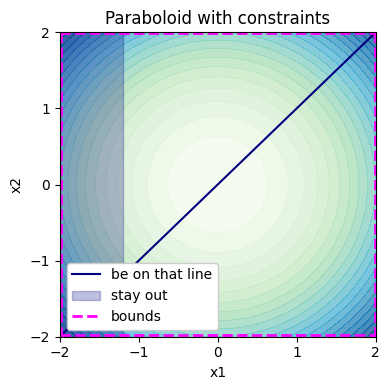

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))


def _wrapped_paraboloid(y):
    return paraboloid(y, None)


limits = (-2, 2)
x = jnp.linspace(*limits, 100)
y = jnp.linspace(*limits, 100)
X, Y = jnp.meshgrid(x, y)
Z = _wrapped_paraboloid((X, Y))
ax.contourf(X, Y, Z, levels=25, cmap="GnBu", alpha=0.75, zorder=-1)

ticks = [-2, -1, 0, 1, 2]
ax.set_xticks(ticks)
ax.set_yticks(ticks)

# circle = plt.Circle((0.5, 0.5), 1, color="firebrick", fill=True, label="stay out")
# ax.add_artist(circle)
ax.plot(limits, limits, color="navy", zorder=0, label="be on that line")

ax.axvspan(-2, -1.2, color="navy", alpha=0.25, zorder=0, label="stay out")

ax.axvline(-1.98, color="magenta", linestyle="--", lw=2, label="bounds")
ax.axvline(1.99, color="magenta", linestyle="--", lw=2)
ax.axhline(-1.98, color="magenta", linestyle="--", lw=2)
ax.axhline(1.99, color="magenta", linestyle="--", lw=2)

ax.set_xlabel("x1")
ax.set_ylabel("x2")

ax.legend(loc="lower left", fancybox=True, framealpha=1)
ax.set_title("Paraboloid with constraints")
fig.tight_layout()